<a href="https://colab.research.google.com/github/AsyrofiAnam/Deteksi-DeepFake-Audio/blob/main/Deteksi_Deepfake_Audio_melalui_Fitur_Mel_Frequency_Cepstral_Coefficients_(MFCC)_menggunakan_Model_Long_Short_Term_Memory_(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Pustaka

In [1]:
!pip install librosa soundfile tensorflow scikit-learn

import librosa
import numpy as np
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Menambahkan Noise (Augmentasi Data)


In [2]:
def tambahkan_noise(audio, faktor_noise=0.005):
    noise = np.random.randn(len(audio))
    audio_augmented = audio + faktor_noise * noise
    return audio_augmented

# Ekstraksi Fitur Dari Audio


In [3]:
def ekstrak_fitur(jalur_file, augment=False):
    audio, sample_rate = librosa.load(jalur_file, sr=None)
    if augment:
        audio = tambahkan_noise(audio)  # Augmentasi dengan menambahkan noise

    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
    spec_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)

    fitur = np.hstack([
        np.mean(mfccs.T, axis=0),
        np.mean(chroma.T, axis=0),
        np.mean(spec_contrast.T, axis=0)
    ])
    return fitur

# Memuat Dataset

In [4]:
# Direktori dataset
jalur_dasar = '/content/drive/MyDrive/JST/UAS/for-2seconds'
jalur_latih_asli = os.path.join(jalur_dasar, 'training/real')
jalur_latih_palsu = os.path.join(jalur_dasar, 'training/fake')
jalur_uji_asli = os.path.join(jalur_dasar, 'testing/real')
jalur_uji_palsu = os.path.join(jalur_dasar, 'testing/fake')

# Ekstraksi fitur dan label
X, y = [], []

for file in os.listdir(jalur_latih_asli):
    if file.endswith('.wav'):
        X.append(ekstrak_fitur(os.path.join(jalur_latih_asli, file)))
        y.append(0)  # Label untuk audio asli

for file in os.listdir(jalur_latih_palsu):
    if file.endswith('.wav'):
        X.append(ekstrak_fitur(os.path.join(jalur_latih_palsu, file)))
        y.append(1)  # Label untuk audio palsu

# Pisahkan data latih dan uji
X_latih, X_uji, y_latih, y_uji = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


# Membangun Model LSTM

In [5]:
# Menyusun data untuk input ke LSTM
X_latih = np.expand_dims(X_latih, axis=2)
X_uji = np.expand_dims(X_uji, axis=2)

# Konversi label menjadi one-hot encoding
y_latih = to_categorical(y_latih, num_classes=2)
y_uji = to_categorical(y_uji, num_classes=2)

# Membuat model LSTM
model = Sequential([
    LSTM(128, input_shape=(X_latih.shape[1], X_latih.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')  # Output layer
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 32, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,114 (461.38 KB)

 Trainable params: 118,114 (461.38 KB)

 Non-trainable params: 0 (0.00 B)

# Melatih Model

In [6]:
history = model.fit(
    X_latih, y_latih,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step - accuracy: 0.5922 - loss: 0.6354 - val_accuracy: 0.8576 - val_loss: 0.3970
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - accuracy: 0.8801 - loss: 0.3055 - val_accuracy: 0.9279 - val_loss: 0.1873
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - accuracy: 0.9169 - loss: 0.2252 - val_accuracy: 0.9128 - val_loss: 0.2281
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - accuracy: 0.9324 - loss: 0.1870 - val_accuracy: 0.9315 - val_loss: 0.1812
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - accuracy: 0.9343 - loss: 0.1768 - val_accuracy: 0.9573 - val_loss: 0.1207
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - accuracy: 0.9479 - loss: 0.1394 - val_accuracy: 0.9613 - val_loss: 0.1149
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 36s 82ms/step - accuracy: 0.9586 - loss: 0.1239 - val_accuracy: 0.9613 - val_loss: 0.1069
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 42s 86ms/step - accuracy: 0.9630 - loss: 0.1002 -

# Menampilkan Grafik Pelatihan Model

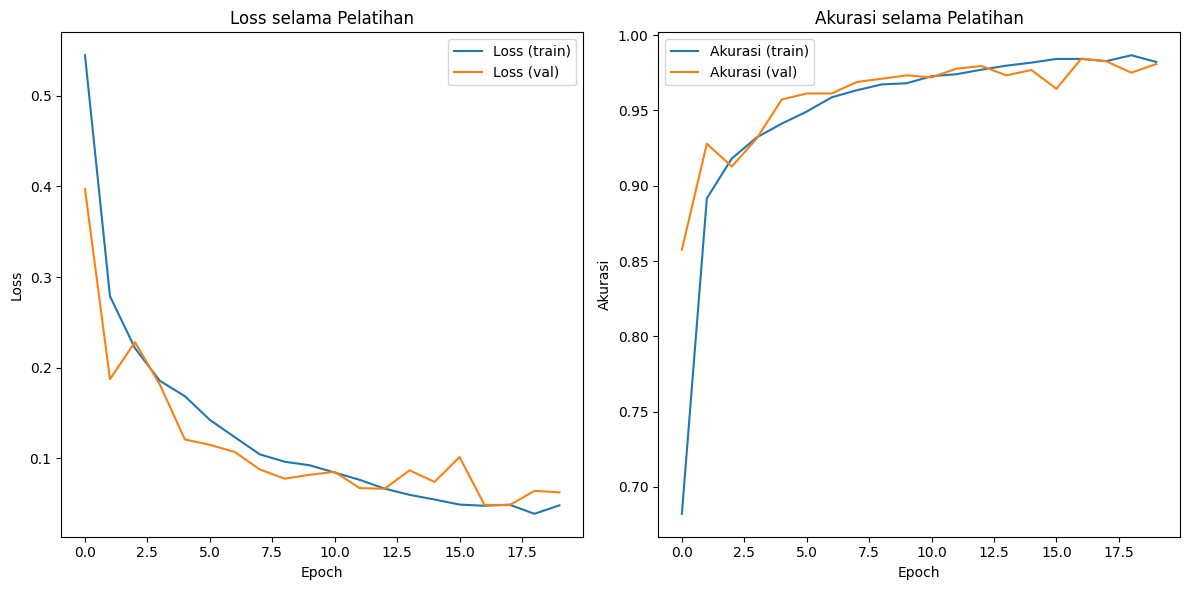

In [7]:
# Menampilkan grafik loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss (train)')
plt.plot(history.history['val_loss'], label='Loss (val)')
plt.title('Loss selama Pelatihan')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Menampilkan grafik akurasi
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Akurasi (train)')
plt.plot(history.history['val_accuracy'], label='Akurasi (val)')
plt.title('Akurasi selama Pelatihan')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluasi Model

In [8]:
# Evaluasi pada data uji
y_pred = model.predict(X_uji)
y_pred_label = np.argmax(y_pred, axis=1)
y_uji_label = np.argmax(y_uji, axis=1)

akurasi = accuracy_score(y_uji_label, y_pred_label)
presisi = precision_score(y_uji_label, y_pred_label)
recall = recall_score(y_uji_label, y_pred_label)
f1 = f1_score(y_uji_label, y_pred_label)

print(f"Akurasi: {akurasi:.4f}")
print(f"Presisi: {presisi:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Skor F1: {f1:.4f}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step
Akurasi: 0.9797
Presisi: 0.9926
Recall: 0.9664
Skor F1: 0.9793


# Menampilkan Confusion Matrix

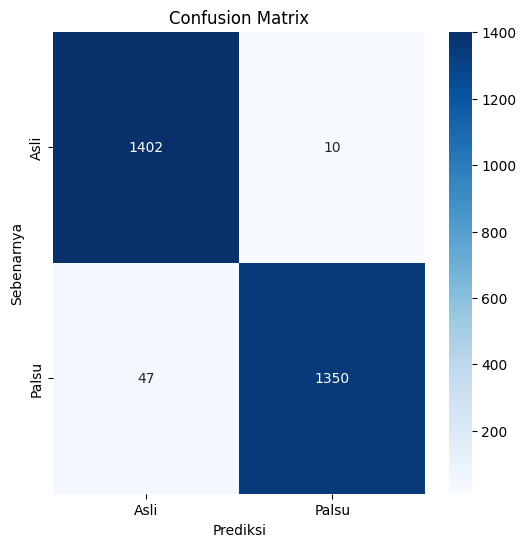

In [9]:
# Confusion Matrix
cm = confusion_matrix(y_uji_label, y_pred_label)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Asli', 'Palsu'], yticklabels=['Asli', 'Palsu'])
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Sebenarnya')
plt.show()

# Prediksi pada File Audio Baru

In [10]:
# Fungsi untuk memprediksi apakah file audio baru itu asli atau palsu
def prediksi_audio_baru(jalur_audio):
    fitur_audio = ekstrak_fitur(jalur_audio)
    fitur_audio = np.expand_dims(fitur_audio, axis=0)  # Menambahkan dimensi untuk batch
    fitur_audio = np.expand_dims(fitur_audio, axis=2)  # Menambahkan dimensi untuk channel

    # Prediksi kelas dan probabilitas
    probabilitas = model.predict(fitur_audio)
    label_prediksi = np.argmax(probabilitas)  # Ambil kelas dengan probabilitas tertinggi
    probabilitas_prediksi = np.max(probabilitas)  # Probabilitas tertinggi

    if label_prediksi == 0:
        hasil = "Audio ASLI"
    else:
        hasil = "Audio PALSU"

    return hasil, probabilitas_prediksi

In [11]:
# Predisi untuk file audio asli
jalur_audio_baru = '/content/drive/MyDrive/JST/UAS/Prediksi_Baru/Suara Asyrofi.ogg'
hasil, probabilitas_prediksi = prediksi_audio_baru(jalur_audio_baru)

print(f"Hasil Prediksi: {hasil}")
print(f"Probabilitas prediksi: {probabilitas_prediksi:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Hasil Prediksi: Audio ASLI
Probabilitas prediksi: 1.00


In [12]:
# Prediksi untuk file audio palsu
jalur_audio_baru = '/content/drive/MyDrive/JST/UAS/Prediksi_Baru/Suara Ai Pak Jokowi.mp3'
hasil, probabilitas_prediksi = prediksi_audio_baru(jalur_audio_baru)

print(f"Hasil Prediksi: {hasil}")
print(f"Probabilitas prediksi: {probabilitas_prediksi:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Hasil Prediksi: Audio PALSU
Probabilitas prediksi: 1.00
